### Get the data from the previous process, split it into seperate dataframes for both pitchers and hitters

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('csv_files/data_merge_output.csv', low_memory=False)

# Seperate dataframes for batters and pitchers
batters = data[data['Role'] == 'Batter']
pitchers = data[data['Role'] == 'Pitcher']

# Filter the dataframes so batters only have batter columns, and pitchers only have pitcher columns
batters = batters[['Rk','Name','Age','Team','Lg','WAR','G','Pos','Awards','Player-additional',
                  'Year','id','Position','Status','Salary', 'Role', 'PA','AB','R','H','2B','3B',
                  'HR','RBI','SB','CS','BB','SO','BA','OBP','SLG', 'OPS','OPS+','rOBA','Rbat+',
                  'TB','GIDP','HBP','SH','SF','IBB']]

pitchers = pitchers[['Rk','Name','Age','Team','Lg','WAR','G','Pos','Awards','Player-additional',
                     'Year','id','Position','Status','Salary', 'Role', 'W','L','W-L%','ERA','GS',
                     'GF','CG','SHO','SV','IP','pH','pR','ER','pHR', 'pBB','pIBB','pSO','pHBP',
                     'BK','WP','BF','ERA+','FIP','WHIP','H9','HR9','BB9','SO9','SO/BB']]

### Perform Predictive Attribute Dependence on our datasets for both pitchers and hitters

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

batting_stats = [
    'PA','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO',
    'BA','OBP','SLG','OPS','OPS+','rOBA','Rbat+','TB','GIDP','HBP','SH','SF','IBB','Age','WAR'
]

pitching_stats = [
    'W','L','ERA','GS','GF','CG','SHO','SV','IP','pH','pR','ER','pHR',
    'pBB','pIBB','pSO','pHBP','BK','WP','BF','ERA+','FIP','WHIP','H9','HR9','BB9','SO9','SO/BB','Age','WAR'
]

def anova_r2(y, clusters):
    """Fraction of variance in y explained by cluster labels (ANOVA-style R²)."""
    y = np.asarray(y).astype(float)
    mask = np.isfinite(y)
    y = y[mask]
    clusters = clusters[mask]

    grand_mean = np.mean(y)
    ss_tot = np.sum((y - grand_mean) ** 2)
    ss_between = sum(len(y[clusters == c]) * (np.mean(y[clusters == c]) - grand_mean) ** 2
                     for c in np.unique(clusters))

    return ss_between / ss_tot if ss_tot > 0 else 0

def predictive_dependence_ranking(df, features, k=6, random_state=42):
    """Ranking the predictive dependence on a specified feature against the others"""
    X = df[features].dropna().copy()
    X_scaled = StandardScaler().fit_transform(X)

    results = []
    for i, col in enumerate(features):
        # Cluster on all other features
        mask = [j for j in range(len(features)) if j != i]
        km = KMeans(n_clusters=k, random_state=random_state, n_init="auto").fit(X_scaled[:, mask])
        labels = km.labels_

        # Measure how well cluster labels explain held-out feature using the ANOVA-style R-squared metric
        score = anova_r2(X_scaled[:, i], labels)
        results.append((col, score))

    # sort descending: highest = most redundant
    return sorted(results, key=lambda x: x[1], reverse=True)

#### Perfoming PAD for batting data

In [3]:
batters_rank = predictive_dependence_ranking(batters, batting_stats)

print("Top batting features by redundancy:")
for feat, score in batters_rank:
    print(f"{feat}: {score:.3f}")

Top batting features by redundancy:
TB: 0.828
PA: 0.799
H: 0.794
R: 0.791
AB: 0.787
RBI: 0.769
2B: 0.696
HR: 0.640
OPS+: 0.633
OPS: 0.633
rOBA: 0.620
Rbat+: 0.608
SLG: 0.594
BB: 0.593
WAR: 0.572
SO: 0.542
OBP: 0.470
BA: 0.431
GIDP: 0.410
SF: 0.355
CS: 0.329
SB: 0.312
IBB: 0.268
3B: 0.254
HBP: 0.207
SH: 0.122
Age: 0.011


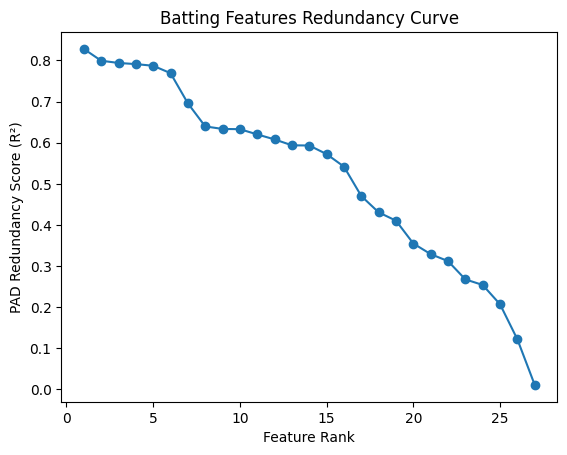

In [4]:
import matplotlib.pyplot as plt

scores = [s for _, s in batters_rank]
plt.plot(range(1, len(scores)+1), scores, marker='o')
plt.xlabel("Feature Rank")
plt.ylabel("PAD Redundancy Score (R²)")
plt.title("Batting Features Redundancy Curve")
plt.show()

#### Performing PAD for pitching data

In [5]:
pitchers_rank = predictive_dependence_ranking(pitchers, pitching_stats)

print("Top pitching features by redundancy:")
for feat, score in pitchers_rank:
    print(f"{feat}: {score:.3f}")

Top pitching features by redundancy:
GS: 0.866
BF: 0.815
IP: 0.812
ER: 0.791
pH: 0.789
pR: 0.785
pSO: 0.687
pHR: 0.679
pBB: 0.641
W: 0.626
L: 0.574
WHIP: 0.436
ERA: 0.390
WAR: 0.385
FIP: 0.355
pHBP: 0.323
GF: 0.314
ERA+: 0.272
CG: 0.268
H9: 0.267
HR9: 0.240
WP: 0.212
SHO: 0.209
SV: 0.204
SO/BB: 0.158
SO9: 0.125
BB9: 0.108
BK: 0.054
pIBB: 0.032
Age: 0.015


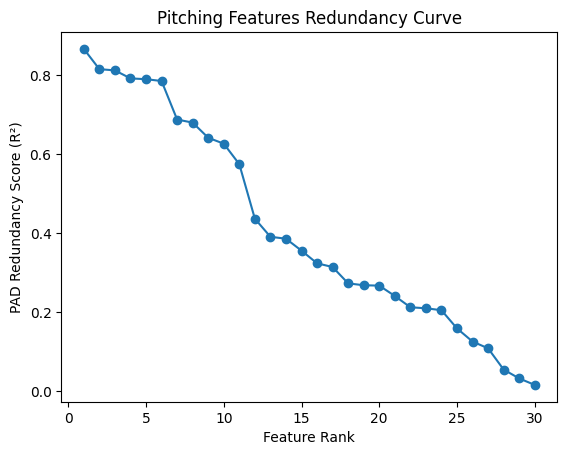

In [6]:
import matplotlib.pyplot as plt

scores = [s for _, s in pitchers_rank]
plt.plot(range(1, len(scores)+1), scores, marker='o')
plt.xlabel("Feature Rank")
plt.ylabel("PAD Redundancy Score (R²)")
plt.title("Pitching Features Redundancy Curve")
plt.show()

From our tests with predictive attribute dependence, I would suggest using the threshold method with a cutoff of .65 for both pitchers and hitters. If we decide to use this cutoff, we will miss out on some highly correlated but still baseball-important stats (like PA for hitters or ER for pitchers), because the model flags them as redundant even though they carry strong interpretive value for player performance.

### Correlation Pruning

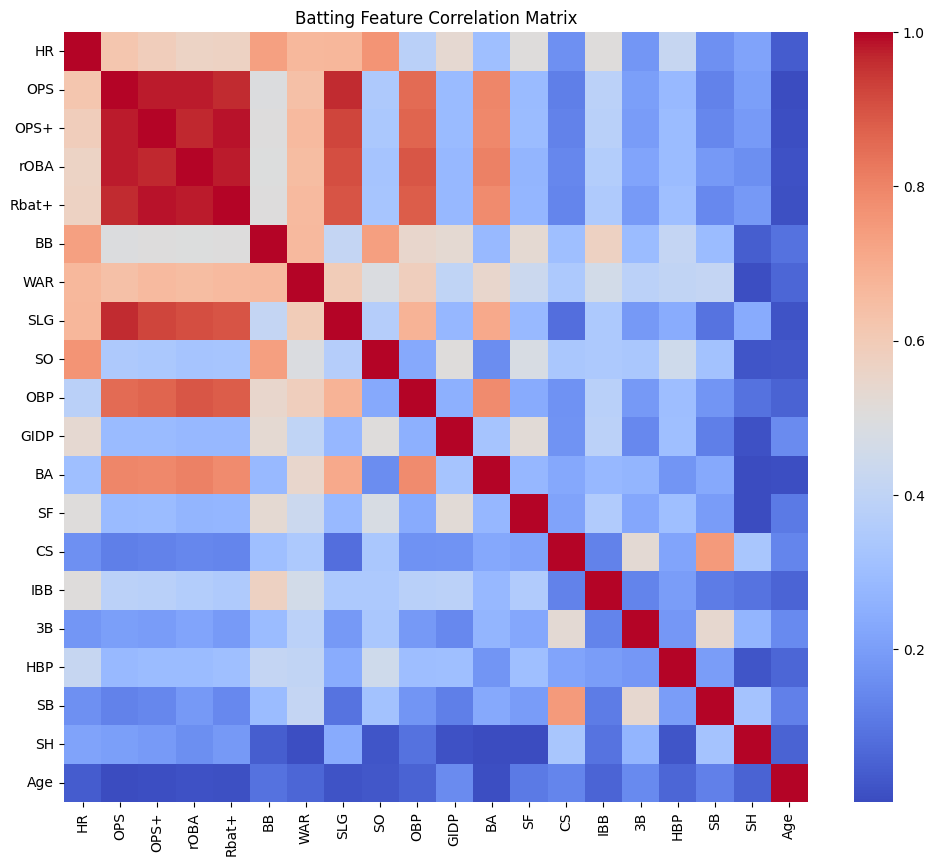

In [7]:
import seaborn as sns

bat_features = [
    'HR','OPS','OPS+','rOBA','Rbat+','BB','WAR','SLG','SO','OBP','GIDP','BA',
    'SF','CS','IBB','3B','HBP','SB','SH','Age'
]

pit_features = [
    'pHR','W','pBB','L','ERA','WHIP','FIP','WAR','pHBP','GF','H9','CG','HR9','SHO',
    'WP','ERA+','SV','SO/BB','SO9','BB9','BK','pIBB','Age'
]

# Compute correlation for batters
corr_bat = batters[bat_features].corr(method='pearson').abs()

plt.figure(figsize=(12,10))
sns.heatmap(corr_bat, cmap='coolwarm', center=0.5)
plt.title("Batting Feature Correlation Matrix")
plt.show()

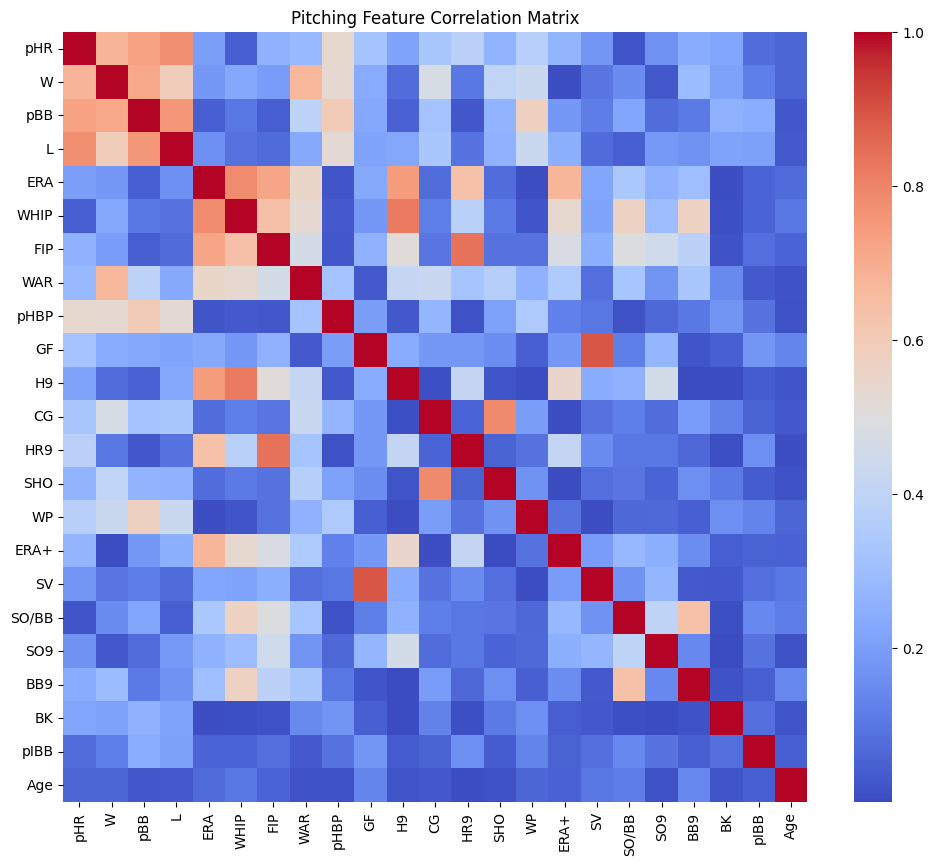

In [8]:
# Compute correlation for batters
corr_pit = pitchers[pit_features].corr(method='pearson').abs()

plt.figure(figsize=(12,10))
sns.heatmap(corr_pit, cmap='coolwarm', center=0.5)
plt.title("Pitching Feature Correlation Matrix")
plt.show()

In [9]:
def drop_highly_correlated(df, threshold=0.82):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop, corr_matrix

# Example for batters
to_drop_bat, corr_bat = drop_highly_correlated(batters[bat_features])
print("Highly correlated batting features to drop:", to_drop_bat)

# Example for pitchers
to_drop_pit, corr_pit = drop_highly_correlated(pitchers[pit_features])
print("Highly correlated pitching features to drop:", to_drop_pit)

bat_final = [f for f in bat_features if f not in to_drop_bat]
pit_final = [f for f in pit_features if f not in to_drop_pit]

print("Final batting features after correlation pruning:", bat_final)
print("Final pitching features after correlation pruning:", pit_final)

Highly correlated batting features to drop: ['OPS+', 'rOBA', 'Rbat+', 'SLG', 'OBP']
Highly correlated pitching features to drop: ['HR9', 'SV']
Final batting features after correlation pruning: ['HR', 'OPS', 'BB', 'WAR', 'SO', 'GIDP', 'BA', 'SF', 'CS', 'IBB', '3B', 'HBP', 'SB', 'SH', 'Age']
Final pitching features after correlation pruning: ['pHR', 'W', 'pBB', 'L', 'ERA', 'WHIP', 'FIP', 'WAR', 'pHBP', 'GF', 'H9', 'CG', 'SHO', 'WP', 'ERA+', 'SO/BB', 'SO9', 'BB9', 'BK', 'pIBB', 'Age']


### PCA to standardize features for clustering

In [10]:
X_bat = batters[bat_final].dropna()
X_pit = pitchers[pit_final].dropna()

scaler_bat = StandardScaler()
scaler_pit = StandardScaler()

Xb_scaled = scaler_bat.fit_transform(X_bat)
Xp_scaled = scaler_pit.fit_transform(X_pit)

In [11]:
from sklearn.decomposition import PCA

# Fit PCA
pca_bat = PCA(random_state=42).fit(Xb_scaled)
pca_pit = PCA(random_state=42).fit(Xp_scaled)

# Cumulative variance
cumvar_bat = np.cumsum(pca_bat.explained_variance_ratio_)
cumvar_pit = np.cumsum(pca_pit.explained_variance_ratio_)

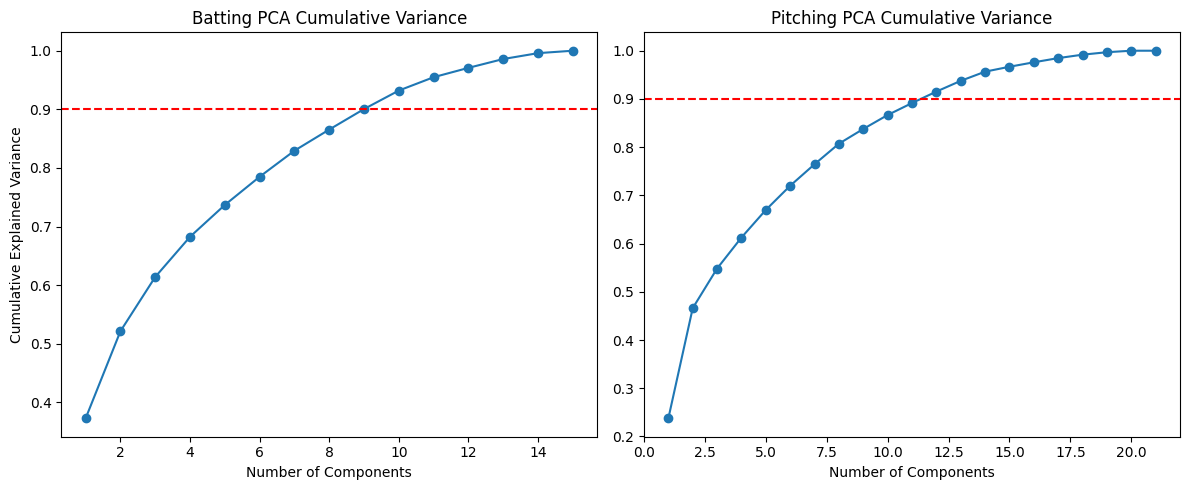

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Batters
ax[0].plot(range(1, len(cumvar_bat)+1), cumvar_bat, marker='o')
ax[0].axhline(0.9, color='r', linestyle='--')
ax[0].set_title("Batting PCA Cumulative Variance")
ax[0].set_xlabel("Number of Components")
ax[0].set_ylabel("Cumulative Explained Variance")

# Pitchers
ax[1].plot(range(1, len(cumvar_pit)+1), cumvar_pit, marker='o')
ax[1].axhline(0.9, color='r', linestyle='--')
ax[1].set_title("Pitching PCA Cumulative Variance")
ax[1].set_xlabel("Number of Components")

plt.tight_layout()
plt.show()

In [13]:
# Loadings (PCA weights)
loadings_bat = pd.DataFrame(
    pca_bat.components_.T,
    columns=[f"PC{i+1}" for i in range(pca_bat.n_components_)],
    index=bat_final
)

loadings_pit = pd.DataFrame(
    pca_pit.components_.T,
    columns=[f"PC{i+1}" for i in range(pca_pit.n_components_)],
    index=pit_final
)

print("Top batting component loadings:")
print(loadings_bat.round(3))

Top batting component loadings:
        PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9   PC10  \
HR    0.348 -0.220 -0.085 -0.212  0.038 -0.058 -0.012  0.186 -0.210 -0.118   
OPS   0.289 -0.172  0.510  0.048  0.147 -0.006  0.003  0.140 -0.111 -0.079   
BB    0.357 -0.094 -0.178 -0.072 -0.096 -0.140  0.148  0.164 -0.099 -0.101   
WAR   0.350  0.016  0.200 -0.041  0.045 -0.028  0.153  0.050  0.019 -0.216   
SO    0.325 -0.023 -0.312 -0.268  0.084 -0.008 -0.132  0.289 -0.266  0.021   
GIDP  0.269 -0.147 -0.223  0.228 -0.208  0.360 -0.255 -0.225 -0.275  0.573   
BA    0.239 -0.010  0.589  0.304  0.033  0.194 -0.108 -0.084 -0.063  0.079   
SF    0.272 -0.080 -0.221  0.173 -0.206  0.293 -0.386 -0.158  0.480 -0.537   
CS    0.202  0.477 -0.044  0.027 -0.003 -0.231 -0.103 -0.364 -0.188  0.004   
IBB   0.251 -0.168 -0.001  0.018 -0.510 -0.227  0.580 -0.232  0.277  0.185   
3B    0.201  0.398  0.060 -0.018 -0.032 -0.109 -0.202  0.510  0.532  0.431   
HBP   0.227 -0.016 -0.192 -0.047

In [14]:
print("\nTop pitching component loadings:")
print(loadings_pit.round(3))


Top pitching component loadings:
         PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9   PC10  \
pHR    0.228  0.314 -0.074 -0.213 -0.122 -0.007  0.084  0.048 -0.141  0.098   
W      0.357  0.178  0.004 -0.030 -0.050 -0.057  0.066 -0.023 -0.001 -0.100   
pBB    0.250  0.300  0.291 -0.044 -0.040 -0.057  0.085 -0.012 -0.015 -0.043   
L      0.223  0.306  0.033 -0.216  0.023  0.010 -0.008 -0.074 -0.034  0.051   
ERA   -0.255  0.304 -0.120 -0.045 -0.069  0.288  0.005 -0.015 -0.074 -0.001   
WHIP  -0.286  0.296  0.076  0.086  0.062  0.149  0.004 -0.030  0.098 -0.187   
FIP   -0.244  0.278 -0.074  0.061 -0.070 -0.111  0.138  0.164 -0.155  0.281   
WAR    0.369 -0.053  0.022  0.122 -0.048 -0.097  0.021 -0.000  0.016 -0.031   
pHBP   0.225  0.215  0.092 -0.118 -0.130 -0.065  0.122  0.013 -0.331  0.277   
GF    -0.028 -0.202  0.234 -0.202  0.407  0.306 -0.021 -0.047  0.079  0.696   
H9    -0.197  0.300 -0.260 -0.127  0.108  0.126 -0.149 -0.128  0.209 -0.167   
CG     0.248  0.12

In [15]:
n_comp_bat = np.argmax(cumvar_bat >= 0.90) + 1
n_comp_pit = np.argmax(cumvar_pit >= 0.90) + 1

print(f"Use {n_comp_bat} batting components and {n_comp_pit} pitching components.")

Use 9 batting components and 12 pitching components.


In [16]:
Z_bat = pca_bat.transform(Xb_scaled)[:, :n_comp_bat]
Z_pit = pca_pit.transform(Xp_scaled)[:, :n_comp_pit]

In [17]:
# Use the number of components explaining 90% of variance
n_comp_bat = np.argmax(np.cumsum(pca_bat.explained_variance_ratio_) >= 0.90) + 1
n_comp_pit = np.argmax(np.cumsum(pca_pit.explained_variance_ratio_) >= 0.90) + 1

# Transform to component space
bat_pca_scores = pca_bat.transform(Xb_scaled)[:, :n_comp_bat]
pit_pca_scores = pca_pit.transform(Xp_scaled)[:, :n_comp_pit]

# Create DataFrames with PCA scores
bat_pca_df = pd.DataFrame(
    bat_pca_scores,
    columns=[f"PC{i+1}" for i in range(n_comp_bat)],
    index=X_bat.index
)

pit_pca_df = pd.DataFrame(
    pit_pca_scores,
    columns=[f"PC{i+1}" for i in range(n_comp_pit)],
    index=X_pit.index
)

# Add identifiers for readability and spot-checking
bat_pca_df = pd.concat([batters.loc[X_bat.index, ['Name', 'Team', 'Year']], bat_pca_df], axis=1)
pit_pca_df = pd.concat([pitchers.loc[X_pit.index, ['Name', 'Team', 'Year']], pit_pca_df], axis=1)

# Merge salary back into the PCA features
bat_pca_df = bat_pca_df.merge(
    batters[['Name', 'Year', 'Salary']],
    on=['Name', 'Year'],
    how='left'
)

pit_pca_df = pit_pca_df.merge(
    pitchers[['Name', 'Year', 'Salary']],
    on=['Name', 'Year'],
    how='left'
)

bat_pca_df['Salary'] = pd.to_numeric(bat_pca_df['Salary'], errors='coerce')
pit_pca_df['Salary'] = pd.to_numeric(pit_pca_df['Salary'], errors='coerce')

# Impute missing salary information by taking the median salary for that specific year
bat_pca_df['Salary'] = bat_pca_df.groupby('Year')['Salary'].transform(lambda x: x.fillna(x.median()))
pit_pca_df['Salary'] = pit_pca_df.groupby('Year')['Salary'].transform(lambda x: x.fillna(x.median()))

In [18]:
# Raw salary values are too skewed (a few $40M contracts dominate)
# This keeps the scale balanced and prevents KMeans from being distorted by a few extreme contracts
bat_pca_df['Salary'] = np.log1p(bat_pca_df['Salary'])
pit_pca_df['Salary'] = np.log1p(pit_pca_df['Salary'])

In [19]:
bat_pca_names = {
    'PC1': 'Overall_Offensive_Production',        # HR, WAR, BB, SO — total batting impact
    'PC2': 'Speed_and_Baserunning_Aggression',    # SB, CS, SH — steals and small-ball
    'PC3': 'Contact_and_OnBase_Efficiency',       # BA, OPS — hit and OBP consistency
    'PC4': 'Experience_and_Longevity',            # Age, WAR — veteran steadiness
    'PC5': 'Plate_Toughness_and_Intentionality',  # HBP vs IBB — intimidation, respect
    'PC6': 'Situational_Contact_Hitting',         # SF, GIDP — run-scoring situational skill
    'PC7': 'Patience_vs_Strikeout_Profile',       # BB, SO — plate discipline spectrum
    'PC8': 'Gap_Power_and_Doubles_Ability',       # 2B, 3B — line-drive power
    'PC9': 'Productive_Baserunning',              # SB, CS, SF — basepath efficiency
}

pit_pca_names = {
    'PC1':  'Workload_and_Volume',        # W, WAR — innings, reliability
    'PC2':  'Run_Prevention',             # ERA, WHIP, FIP — limiting runs and hits
    'PC3':  'Command_and_Control',        # BB9, SO/BB — strike throwing, walk rate
    'PC4':  'Stamina_and_CompleteGames',  # CG, SHO — old-school endurance
    'PC5':  'Bullpen_Leverage',           # GF, pIBB — late-inning usage
    'PC6':  'Strikeout_Dominance',        # SO9, SO/BB — power pitching and swing-miss
    'PC7':  'Veteran_Pitching_Style',     # Age, pIBB — age-related style adaptations
    'PC8':  'Mechanical_Volatility',      # BK, WP — inconsistency or control issues
    'PC9':  'Pressure_Composure',         # WP, HBP — command under duress
    'PC10': 'Relief_Effectiveness',       # GF, WP — reliever impact
    'PC11': 'Overall_Performance Value',  # WAR, FIP, ERA+ — balanced performance value
    'PC12': 'Sabermetric_Efficiency'      # WAR, ERA+, FIP, SO/BB — modern metrics composite
}

bat_pca_df = bat_pca_df.rename(columns=bat_pca_names)
pit_pca_df = pit_pca_df.rename(columns=pit_pca_names)

scaler = StandardScaler()

# Scale salary in each dataset independently, weight salary so it explains about .3 of the variance in the selected feature set
bat_pca_df['Salary'] = scaler.fit_transform(bat_pca_df[['Salary']])
pit_pca_df['Salary'] = scaler.fit_transform(pit_pca_df[['Salary']])

pit_salary_weight = 23 / 8 # Can be changed to weight salary differently in comparison to the other PCA features, this accounts for about .3
bat_salary_weight = 77 / 32

bat_pca_df['Salary'] = bat_pca_df['Salary'] * bat_salary_weight
pit_pca_df['Salary'] = pit_pca_df['Salary'] * pit_salary_weight

bat_pca_df.to_csv("csv_files/batters_pca_features.csv", index=False)
pit_pca_df.to_csv("csv_files/pitchers_pca_features.csv", index=False)

#### Checking total PCA variances with the inclusion of salary for clustering, salary should be .3 of total

In [20]:
bat_pca_numeric = bat_pca_df.drop(columns=['Name', 'Team', 'Year'])
variance_summary = bat_pca_numeric.var().sort_values(ascending=False)

total_variance = variance_summary.sum()

print("Variance by batting feature:\n\n", variance_summary)
print("\nTotal sum of variances:", total_variance)

Variance by batting feature:

 Salary                                5.791102
Overall_Offensive_Production          5.594630
Speed_and_Baserunning_Aggression      2.229051
Contact_and_OnBase_Efficiency         1.389920
Experience_and_Longevity              1.028217
Plate_Toughness_and_Intentionality    0.813822
Situational_Contact_Hitting           0.721295
Patience_vs_Strikeout_Profile         0.666339
Gap_Power_and_Doubles_Ability         0.540463
Productive_Baserunning                0.524786
dtype: float64

Total sum of variances: 19.299624355310225


In [21]:
pit_pca_numeric = pit_pca_df.drop(columns=['Name', 'Team', 'Year'])
variance_summary = pit_pca_numeric.var().sort_values(ascending=False)

total_variance = variance_summary.sum()

print("Variance by pitching feature:\n\n", variance_summary)
print("\n\nTotal sum of variances:", total_variance)

Variance by pitching feature:

 Salary                       8.267129
Workload_and_Volume          5.013825
Run_Prevention               4.811860
Command_and_Control          1.730574
Stamina_and_CompleteGames    1.355832
Bullpen_Leverage             1.201783
Strikeout_Dominance          1.053572
Veteran_Pitching_Style       0.934355
Mechanical_Volatility        0.892347
Pressure_Composure           0.644274
Relief_Effectiveness         0.605354
Overall_Performance Value    0.521652
Sabermetric_Efficiency       0.499226
dtype: float64


Total sum of variances: 27.53178343444597
